In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pylab import *
import seaborn as sns
sns.set(font=['TakaoPGothic'], font_scale=1.2)
import numpy as np
import pandas as pd
from typing import List, Tuple, Optional

# IoU and True-Positive

In [2]:
def calc_iou(true: np.ndarray, pred: np.ndarray) -> np.ndarray:
    assert len(true.shape) == len(pred.shape) == 2
    assert true.shape[1] == pred.shape[1] == 4
    ex_like = np.zeros((pred.shape[0], true.shape[0], pred.shape[1]))
    ex_true = np.full_like(ex_like, true[np.newaxis, :, :], dtype=np.float)
    ex_pred = np.full_like(ex_like, pred[:, np.newaxis, :], dtype=np.float)
    
    def calc_area_3d(bbox: np.ndarray) -> np.ndarray:
        return (
            bbox[:, :, 2] - bbox[:, :, 0]
        ) * (
            bbox[:, :, 3] - bbox[:, :, 1]
        )
    
    area_true = calc_area_3d(ex_true)
    area_pred = calc_area_3d(ex_pred)
    left_ups = np.maximum(ex_true[:, :, :2], ex_pred[:, :, :2])
    right_downs = np.minimum(ex_true[:, :, 2:], ex_pred[:, :, 2:])
    intersections = np.maximum(right_downs - left_ups, 0.0)
    area_inter = intersections[:, :, 0] * intersections[:, :, 1]
    area_union = area_true + area_pred - area_inter
    return np.maximum(1.0 * area_inter / area_union, np.finfo(np.float).eps)

In [3]:
def calc_tp(iou: np.ndarray, threshold: float) -> np.ndarray:
    masked = np.where(iou >= threshold, iou, 0)
    for i in range(preds.shape[0]):
        if masked[i, :].max() <= 0:
            continue
        ind = np.argmax(masked[i, :])
        masked[i, :] = 0
        masked[:, ind] = 0
        masked[i, ind] = 1
    return np.where(masked > 0, 1, 0).sum(axis=1)[:, np.newaxis]

In [4]:
trues = np.array([
    [20, 20, 40, 40],
    [25, 25, 50, 50],
])
preds = np.array([
    [10, 10, 30, 30, 0.9],
    [30, 10, 50, 30, 0.8],
    [10, 30, 30, 50, 0.7],
    [30, 30, 50, 50, 0.6],
    [10, 20, 30, 40, 0.5],
    [20, 10, 40, 30, 0.4],
    [30, 20, 50, 40, 0.3],
    [20, 30, 40, 50, 0.2],
    [40, 40, 60, 60, 0.1],
])

In [5]:
iou = calc_iou(true=trues[:, :4], pred=preds[:, :4])
tp = calc_tp(iou=iou, threshold=0.2)
np.concatenate(((iou * 100).astype(int), tp), axis=1)

array([[14,  2,  0],
       [14, 10,  0],
       [14, 10,  0],
       [14, 64,  1],
       [33,  7,  1],
       [33,  7,  0],
       [33, 41,  0],
       [33, 41,  0],
       [ 0, 10,  0]])

# Average Precision and Average Recall

In [6]:
def calc_auc(x: np.ndarray, y: np.ndarray) -> float:
    area_points = list()
    tmp_points = list(zip(x, y))
    key_point = tmp_points[0]
    if len(tmp_points) == 1:
        area_points.append(key_point)
    else:
        for i, tmp_point in enumerate(tmp_points[1:]):
            if tmp_point[1] > key_point[1]:
                if tmp_point[0] < key_point[0]:
                    area_points.append(key_point)
                key_point = tmp_point
            if i == len(tmp_points) - 2:
                area_points.append(key_point)
    auc = 0
    base_x = 0
    for area_point in area_points[::-1]:
        auc += (area_point[0] - base_x) * area_point[1]
        base_x = area_point[0]
    return auc, area_points

In [7]:
def calc_metrics(tp: List[int], n_true: int, maxdet: Optional[int] = None) -> Tuple:
    acc_tp = np.cumsum(np.array(tp))
    n_pred = len(tp)
    precision = acc_tp / np.array(list(range(1, n_pred + 1)))
    recall = acc_tp / n_true
    if maxdet is not None:
        precision = precision[:maxdet]
        recall = recall[:maxdet]
    ap, ap_area = calc_auc(x=recall[::-1], y=precision[::-1])
    ar, ar_area = calc_auc(x=precision, y=recall)
    return precision, recall, ap, ap_area, ar, ar_area

In [8]:
def draw_interpolated_area(
    tp: List[int],
    n_true: Optional[int] = None,
    maxdet: Optional[int] = None
) -> None:
    if n_true is None:
        n_true = sum(tp)
    precision, recall, ap, ap_area, ar, ar_area = calc_metrics(
        tp=tp,
        n_true=n_true,
        maxdet=maxdet
    )
    fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    pd.DataFrame({'precision': precision, 'recall': recall}).plot(
        kind='line', x='recall', y='precision', c='blue', lw=2, ax=ax1
    )
    pd.DataFrame({
        'precision': np.array(ap_area)[:, 1],
        'recall': np.array(ap_area)[:, 0],
    }).plot(
        kind='scatter', x='recall', y='precision', ax=ax1, c=['red'], s=40
    )
    base_x = 0
    for area_p in ap_area[::-1]:
        rect = patches.Rectangle(
            (base_x, 0), area_p[0] - base_x, area_p[1],
            edgecolor='green', facecolor='none', lw=1
        )
        ax1.add_patch(rect)
        base_x = area_p[0]
    ax1.set_xlim(-0.03, 1.03)
    ax1.set_ylim(-0.03, 1.03)
    ax1.legend().remove()
    ax1.set_title(f'Average Precision: {ap:.5}')
    pd.DataFrame({'precision': precision, 'recall': recall}).plot(
        kind='line', x='precision', y='recall', c='blue', lw=2, ax=ax2
    )
    pd.DataFrame({
        'precision': np.array(ar_area)[:, 0],
        'recall': np.array(ar_area)[:, 1],
    }).plot(
        kind='scatter', x='precision', y='recall', ax=ax2, c=['red'], s=40
    )
    base_x = 0
    for area_p in ar_area[::-1]:
        rect = patches.Rectangle(
            (base_x, 0), area_p[0] - base_x, area_p[1],
            edgecolor='green', facecolor='none', lw=1
        )
        ax2.add_patch(rect)
        base_x = area_p[0]
    ax2.set_xlim(-0.03, 1.03)
    ax2.set_ylim(-0.03, 1.03)
    ax2.legend().remove()
    ax2.set_title(f'Average Recall: {ar:.5}')
    return

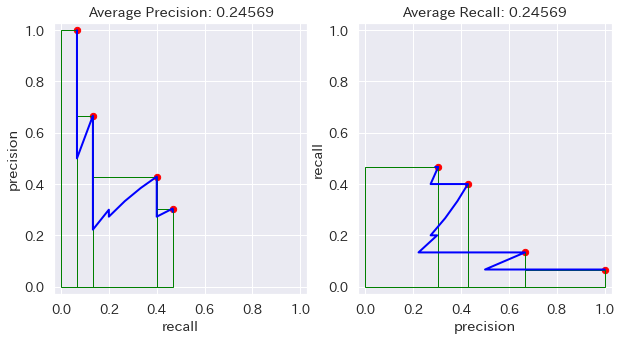

In [9]:
draw_interpolated_area(
    tp=[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    n_true=15
)

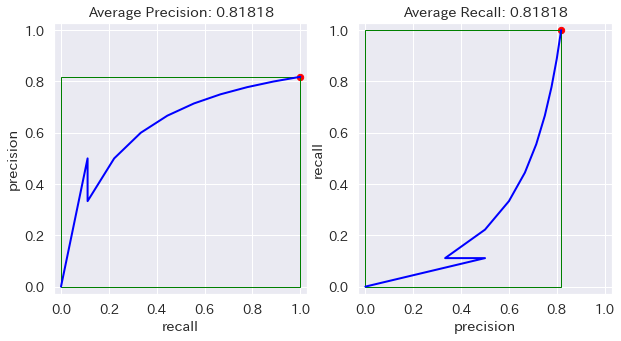

In [10]:
draw_interpolated_area(
    tp=[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
)

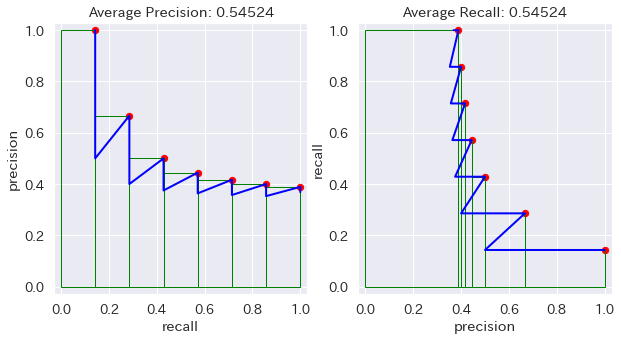

In [11]:
draw_interpolated_area(
    tp=[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]
)

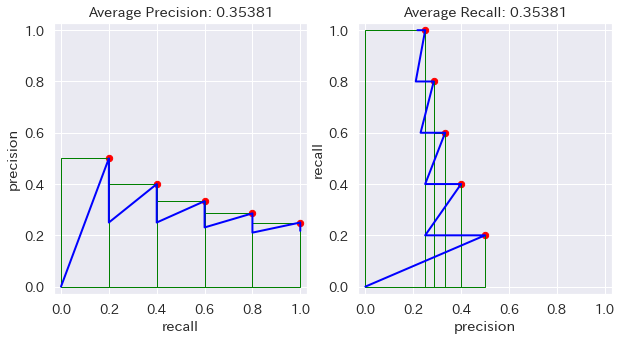

In [12]:
draw_interpolated_area(
    tp=[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
)

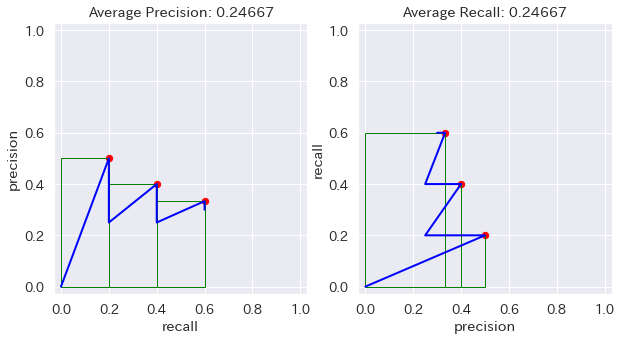

In [13]:
draw_interpolated_area(
    tp=[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    maxdet=10
)

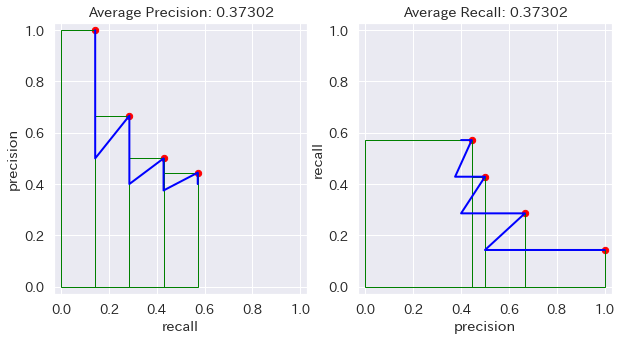

In [14]:
draw_interpolated_area(
    tp=[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    maxdet=10
)